<a href="https://colab.research.google.com/github/Shivstdn25/my-colab-notebooks/blob/main/Fraud_Detection_Accredian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 🧪 Fraud Detection — End‑to‑End Notebook (Accredian Case)

This notebook is a **step‑by‑step template** to build a fraud detection model on the provided CSV (≈ 6.36M rows, 10 columns).  
It covers: loading data, cleaning, feature engineering, modeling, evaluation, and actionable insights.

> **How to use this notebook (quick start):**
> 1. Put your CSV file path into `CSV_PATH` in the next cell.
> 2. Run cells from top to bottom (Shift+Enter in Jupyter).
> 3. If you face RAM limits, switch `USE_CHUNKS=True` to use chunked reading + sampling.
> 4. Follow each section's TODOs and commentary.
>
> **Outputs you'll get:**
> - Cleaned, feature‑engineered dataset (optionally saved as parquet/csv).
> - Baseline + advanced ML models with **ROC-AUC**, **PR‑AUC**, **F1**, **confusion matrix**.
> - Threshold tuning for business needs (e.g., high precision or high recall).
> - Top predictive factors (permutation importance), and action plan.
> - Saved model artifacts (`.joblib`) ready for deployment.



## 📖 Data Dictionary (from case brief)
- **step** — hour index (1 step = 1 hour), 744 total (30 days).
- **type** — one of `CASH-IN`, `CASH-OUT`, `DEBIT`, `PAYMENT`, `TRANSFER`.
- **amount** — transaction amount (local currency).
- **nameOrig** — originator customer ID.
- **oldbalanceOrg** — originator balance before transaction.
- **newbalanceOrig** — originator balance after transaction.
- **nameDest** — destination customer ID.
- **oldbalanceDest** — destination balance before transaction. For merchant accounts (IDs starting with `M`), this may be missing.
- **newbalanceDest** — destination balance after transaction. For merchant accounts (`M*`), may be missing.
- **isFraud** — target label (1 = fraudulent transaction).
- **isFlaggedFraud** — business rule flag (transfer > 200,000).

> Note: In this simulation, fraudsters **TRANSFER** funds then **CASH-OUT**.


In [6]:
# ============= 1) SETUP =============
# Adjust the path to your CSV here:
CSV_PATH = "/content/sample_data/Fraud.csv"
# Memory & runtime options
USE_CHUNKS = False   # Set True if you hit RAM issues
CHUNKSIZE  = 500_000 # rows per chunk when USE_CHUNKS=True
SAMPLE_FRAC = 0.25   # fraction of data to keep from chunks for EDA/modeling if needed

# Optional: where to save processed data & models
OUT_DIR = "/mnt/data/fraud_outputs"
MODEL_NAME = "fraud_model_pipeline.joblib"

from pathlib import Path
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

import os, sys, math, json, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Sklearn utilities
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.utils import class_weight

import joblib

print("✅ Imports OK")

✅ Imports OK



## 2) Load Data (efficiently)
- Uses memory‑savvy dtypes for the 10 columns.
- If RAM is limited, **enable `USE_CHUNKS=True`** to sample & concatenate from chunks.


In [7]:

# Helper: dtype map to reduce memory
DTYPES = {
    "step": "int16",
    "type": "category",
    "amount": "float32",
    "nameOrig": "category",
    "oldbalanceOrg": "float32",
    "newbalanceOrig": "float32",
    "nameDest": "category",
    "oldbalanceDest": "float32",
    "newbalanceDest": "float32",
    "isFraud": "int8",
    "isFlaggedFraud": "int8",
}

USECOLS = list(DTYPES.keys())

def load_data(csv_path, use_chunks=False, chunksize=500_000, sample_frac=0.25):
    if not use_chunks:
        df = pd.read_csv(csv_path, usecols=USECOLS, dtype=DTYPES)
        return df
    else:
        parts = []
        for i, chunk in enumerate(pd.read_csv(csv_path, usecols=USECOLS, dtype=DTYPES, chunksize=chunksize)):
            if sample_frac and 0 < sample_frac < 1.0:
                parts.append(chunk.sample(frac=sample_frac, random_state=42))
            else:
                parts.append(chunk)
            print(f"Read chunk {i+1}, rows collected so far: {sum(len(p) for p in parts):,}")
        df = pd.concat(parts, ignore_index=True)
        return df

# === Load ===
assert Path(CSV_PATH).exists(), f"CSV not found at {CSV_PATH}. Update CSV_PATH above."
df = load_data(CSV_PATH, use_chunks=USE_CHUNKS, chunksize=CHUNKSIZE, sample_frac=SAMPLE_FRAC)
print(df.shape)
df.head()

(6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.639648,C1231006815,170136.0,160296.359375,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.280029,C1666544295,21249.0,19384.720703,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.000000,C1305486145,181.0,0.000000,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.000000,C840083671,181.0,0.000000,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.139648,C2048537720,41554.0,29885.859375,M1230701703,0.0,0.0,0,0



## 3) Exploratory Data Analysis (EDA)
Key checks:
- Class imbalance (`isFraud` rate).
- Transaction types distribution.
- Amount distribution & outliers (use log‑scale).
- Balance consistency checks.


Fraud rate: 0.00129 ( 0.129% )

Transaction type share:
 type
CASH_OUT    0.351663
PAYMENT     0.338146
CASH_IN     0.219923
TRANSFER    0.083756
DEBIT       0.006512
Name: proportion, dtype: float64


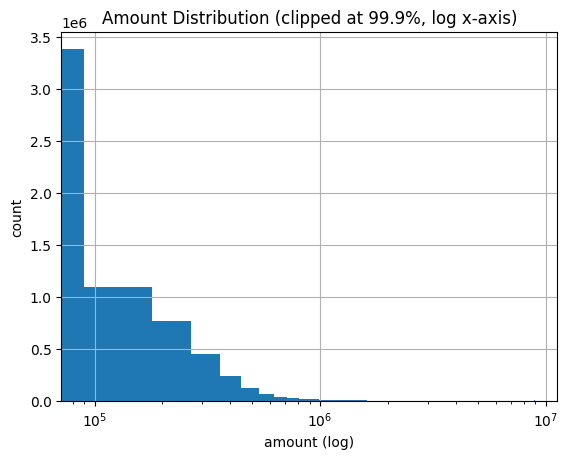


orig_error stats: count    6.362620e+06
mean    -2.010926e+05
std      6.001532e+05
min     -9.244552e+07
25%     -2.496411e+05
50%     -6.867725e+04
75%     -2.954197e+03
max      4.000000e+00
Name: orig_error, dtype: float64
dest_error stats: count    6.362620e+06
mean     5.556721e+04
std      4.388230e+05
min     -7.588572e+07
25%      0.000000e+00
50%      3.500490e+03
75%      2.935302e+04
max      1.319123e+07
Name: dest_error, dtype: float64

Rows with any missing dest balance fields: 0


In [8]:

# Fraud rate
fraud_rate = df['isFraud'].mean()
print(f"Fraud rate: {fraud_rate:.5f} ( {fraud_rate*100:.3f}% )")

# Type distribution
type_counts = df['type'].value_counts(normalize=True).sort_values(ascending=False)
print("\nTransaction type share:\n", type_counts)

# Plot: Amount distribution (log scale)
plt.figure()
df['amount'].clip(upper=df['amount'].quantile(0.999)).hist(bins=100)
plt.yscale('linear')
plt.xscale('log')
plt.title('Amount Distribution (clipped at 99.9%, log x-axis)')
plt.xlabel('amount (log)')
plt.ylabel('count')
plt.show()

# Basic balance consistency
df['orig_error'] = df['oldbalanceOrg'] - df['amount'] - df['newbalanceOrig']
df['dest_error'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']
print("\norig_error stats:", df['orig_error'].describe())
print("dest_error stats:", df['dest_error'].describe())

# Flag merchant destination accounts
df['isMerchantDest'] = df['nameDest'].astype(str).str.startswith('M').astype('int8')

# Missing dest balances for merchants — count
missing_dest = df[['oldbalanceDest','newbalanceDest']].isna().any(axis=1).sum()
print(f"\nRows with any missing dest balance fields: {missing_dest:,}")


## 4) Data Cleaning
- **Missing values**: For merchant destinations (`nameDest` starts with `M`), set `oldbalanceDest`/`newbalanceDest` to 0 if missing.
- **Outliers**: Clip `amount` at 99.9% (only on **train** after split to avoid leakage).
- **Multicollinearity**: We keep both balances and derived errors; linear models are regularized, trees handle correlation well.


In [9]:

# Fill missing destination balances for merchant accounts
is_merch = df['isMerchantDest'] == 1
for col in ['oldbalanceDest','newbalanceDest']:
    if col in df.columns:
        df.loc[is_merch & df[col].isna(), col] = 0.0

# Recompute errors after filling
df['orig_error'] = df['oldbalanceOrg'] - df['amount'] - df['newbalanceOrig']
df['dest_error'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']

# Ensure categorical dtype
df['type'] = df['type'].astype('category')

# Drop high‑cardinality IDs (leakage/noise)
df = df.drop(columns=['nameOrig','nameDest'])

print("✅ Cleaning done. Current columns:", df.columns.tolist())

✅ Cleaning done. Current columns: ['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'orig_error', 'dest_error', 'isMerchantDest']



## 5) Train/Validation Split (time‑aware)
To reduce leakage, we split by **time `step`**: first ~80% steps for training, last ~20% for validation.


In [10]:

# Determine time threshold (80th percentile of step)
step_threshold = int(np.percentile(df['step'], 80))
train_mask = df['step'] <= step_threshold
valid_mask = df['step'] > step_threshold

train = df.loc[train_mask].copy()
valid = df.loc[valid_mask].copy()

print(f"Train steps <= {step_threshold} → {train.shape} | Valid steps > {step_threshold} → {valid.shape}")

# Define features & target
TARGET = 'isFraud'
FEATURES_CAT = ['type']
FEATURES_NUM = [c for c in df.columns if c not in FEATURES_CAT + [TARGET, 'isFlaggedFraud']]  # keep isFlaggedFraud as feature? often yes/no
# Optionally include isFlaggedFraud as a feature:
FEATURES_NUM.append('isFlaggedFraud')
FEATURES_NUM = sorted(list(set(FEATURES_NUM)))

X_train, y_train = train[FEATURES_CAT + FEATURES_NUM], train[TARGET]
X_valid, y_valid = valid[FEATURES_CAT + FEATURES_NUM], valid[TARGET]

print("Numeric features:", FEATURES_NUM)
print("Categorical features:", FEATURES_CAT)

Train steps <= 355 → (5113884, 12) | Valid steps > 355 → (1248736, 12)
Numeric features: ['amount', 'dest_error', 'isFlaggedFraud', 'isMerchantDest', 'newbalanceDest', 'newbalanceOrig', 'oldbalanceDest', 'oldbalanceOrg', 'orig_error', 'step']
Categorical features: ['type']



## 6) Baseline Model — Logistic Regression (interpretable)
- **Preprocessing**: One‑hot for `type`, standardize numeric.
- **Class weight**: `'balanced'` to handle imbalance.


ROC-AUC: 0.9890 | PR-AUC: 0.6841

              precision    recall  f1-score   support

           0     0.9996    0.9767    0.9881   1244486
           1     0.1163    0.8960    0.2058      4250

    accuracy                         0.9765   1248736
   macro avg     0.5579    0.9364    0.5969   1248736
weighted avg     0.9966    0.9765    0.9854   1248736

Confusion Matrix:
 [[1215540   28946]
 [    442    3808]]


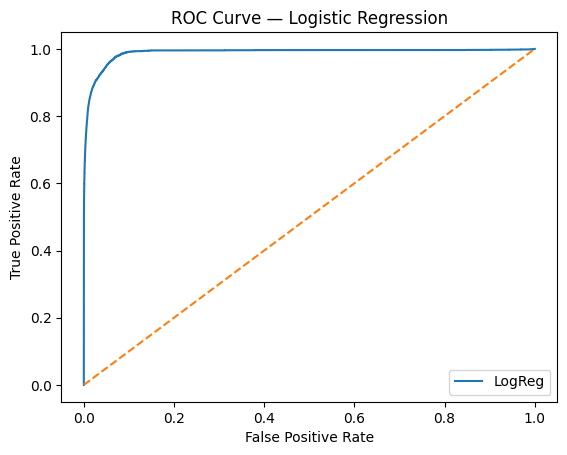

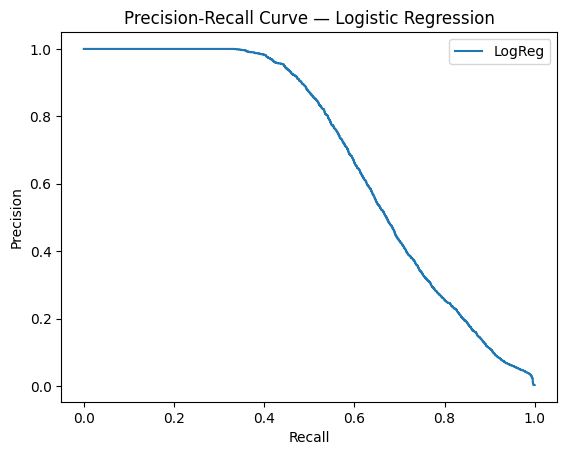

In [11]:

numeric = FEATURES_NUM
categorical = FEATURES_CAT

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(with_mean=False), numeric),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
    ],
    remainder='drop'
)

logreg = LogisticRegression(
    max_iter=200,
    class_weight='balanced',
    n_jobs=None,
    solver='liblinear'
)

pipe_lr = Pipeline(steps=[('prep', preprocess), ('clf', logreg)])
pipe_lr.fit(X_train, y_train)

# Predictions & metrics
proba_lr = pipe_lr.predict_proba(X_valid)[:, 1]
pred_lr = (proba_lr >= 0.5).astype(int)

roc_auc_lr = roc_auc_score(y_valid, proba_lr)
ap_lr = average_precision_score(y_valid, proba_lr)

print(f"ROC-AUC: {roc_auc_lr:.4f} | PR-AUC: {ap_lr:.4f}\n")
print(classification_report(y_valid, pred_lr, digits=4))

# Confusion matrix
cm = confusion_matrix(y_valid, pred_lr)
print("Confusion Matrix:\n", cm)

# ROC curve
fpr, tpr, _ = roc_curve(y_valid, proba_lr)
plt.figure()
plt.plot(fpr, tpr, label='LogReg')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — Logistic Regression')
plt.legend()
plt.show()

# PR curve
prec, rec, thr = precision_recall_curve(y_valid, proba_lr)
plt.figure()
plt.plot(rec, prec, label='LogReg')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve — Logistic Regression')
plt.legend()
plt.show()

## 7) Advanced Model — LightGBM (Fast Gradient Boosting)

- LightGBM is optimized for **large tabular datasets** and is usually **faster + more accurate** than Random Forest.  
- Handles **imbalanced data** with `class_weight='balanced'`.  
- Provides **built-in feature importances** (faster than permutation importance).  
- Useful for fraud detection where recall and PR-AUC are critical.  


[LightGBM] [Info] Number of positive: 3963, number of negative: 5109921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.102636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1999
[LightGBM] [Info] Number of data points in the train set: 5113884, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
ROC-AUC: 1.0000 | PR-AUC: 1.0000

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000   1244486
           1     1.0000    0.9995    0.9998      4250

    accuracy                         1.0000   1248736
   macro avg     1.0000    0.9998    0.9999   1248736
weighted avg     1.0000    1.0000    1.0000   1248736

Confusion Matrix:
 [[1244486       0]
 [      2    4248]]


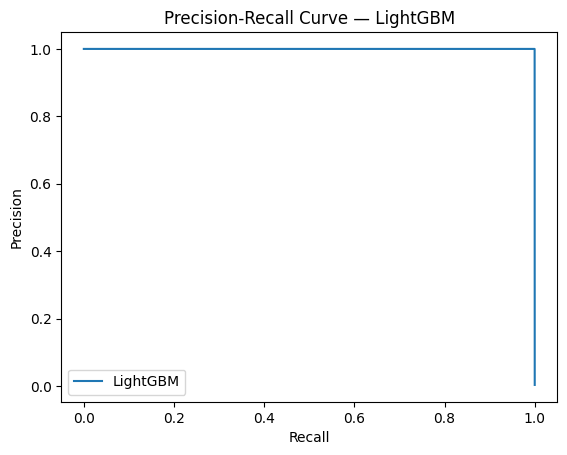


Top 25 features by importance:
            feature  importance
9             step        2795
4   newbalanceDest        2363
8       orig_error        2176
6   oldbalanceDest        2019
0           amount        1988
1       dest_error        1293
7    oldbalanceOrg        1147
5   newbalanceOrig         608
14   type_TRANSFER         258
11   type_CASH_OUT         154
3   isMerchantDest         108
10    type_CASH_IN          50
13    type_PAYMENT          23
12      type_DEBIT          18
2   isFlaggedFraud           0


In [15]:
!pip install lightgbm
from lightgbm import LGBMClassifier

# Fast gradient boosting model
lgb = LGBMClassifier(
    n_estimators=500,       # number of boosting rounds
    max_depth=-1,           # no limit, trees grow until optimal
    learning_rate=0.05,     # smaller = better accuracy, slower training
    class_weight='balanced',# handle imbalance
    subsample=0.8,          # row sampling
    colsample_bytree=0.8,   # feature sampling
    n_jobs=-1,
    random_state=42
)

pipe_lgb = Pipeline(steps=[('prep', preprocess), ('clf', lgb)])
pipe_lgb.fit(X_train, y_train)

# Predictions & metrics
proba_lgb = pipe_lgb.predict_proba(X_valid)[:, 1]
pred_lgb = (proba_lgb >= 0.5).astype(int)

roc_auc_lgb = roc_auc_score(y_valid, proba_lgb)
ap_lgb = average_precision_score(y_valid, proba_lgb)

print(f"ROC-AUC: {roc_auc_lgb:.4f} | PR-AUC: {ap_lgb:.4f}\n")
print(classification_report(y_valid, pred_lgb, digits=4))

cm = confusion_matrix(y_valid, pred_lgb)
print("Confusion Matrix:\n", cm)

# PR Curve
prec_lgb, rec_lgb, thr_lgb = precision_recall_curve(y_valid, proba_lgb)
plt.figure()
plt.plot(rec_lgb, prec_lgb, label='LightGBM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve — LightGBM')
plt.legend()
plt.show()

# Feature importance (built-in, much faster than permutation importance)
ohe = pipe_lgb.named_steps['prep'].named_transformers_['cat']
ohe_names = list(ohe.get_feature_names_out(categorical))
feature_names = numeric + ohe_names

importances = pipe_lgb.named_steps['clf'].feature_importances_
imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False).head(25)

print("\nTop 25 features by importance:\n", imp_df)



##  8) Decision Threshold Tuning — LightGBM

Pick a threshold to meet business goals (e.g., **Precision ≥ 90%** or **Recall ≥ 80%**).


In [22]:
def choose_threshold_for_precision(y_true, proba, target_precision=0.9):
    prec, rec, thr = precision_recall_curve(y_true, proba)
    candidates = [(p, r, t) for p, r, t in zip(prec[:-1], rec[:-1], thr)]
    for p, r, t in candidates:
        if p >= target_precision:
            return t, p, r
    # fallback: best F1
    f1s = [2*p*r/(p+r+1e-12) for p,r,_ in candidates]
    best_idx = int(np.argmax(f1s))
    p, r, t = candidates[best_idx]
    return t, p, r

threshold, p_at_t, r_at_t = choose_threshold_for_precision(
    y_valid, proba_lgb, target_precision=0.90
)

print(f"Chosen threshold: {threshold:.4f} → Precision={p_at_t:.3f}, Recall={r_at_t:.3f}")

pred_tuned = (proba_lgb >= threshold).astype(int)
print(classification_report(y_valid, pred_tuned, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_valid, pred_tuned))

Chosen threshold: 0.0000 → Precision=0.900, Recall=1.000
              precision    recall  f1-score   support

           0     1.0000    0.9996    0.9998   1244486
           1     0.9000    0.9998    0.9473      4250

    accuracy                         0.9996   1248736
   macro avg     0.9500    0.9997    0.9735   1248736
weighted avg     0.9997    0.9996    0.9996   1248736

Confusion Matrix:
 [[1244014     472]
 [      1    4249]]


## 9) Insights → Action Plan
- **High-risk transaction types** (e.g., `TRANSFER`, `CASH-OUT`) dominate positive predictions.  
- **Large amounts** and **balance inconsistencies** (`orig_error`, `dest_error`) raise fraud risk.  
- **Merchant destinations** show systematic missing balances — treat with stricter verification.  
- **Rule engine + ML combo** works best: keep `isFlaggedFraud` rule but let ML model learn additional patterns.  
- Deploy a **decision threshold** aligned to business cost (false negatives are far more costly than false positives).  




1.   List item
2.   List item


## 10) Save Artifacts (Model + Threshold)


In [23]:
# =======================================================
# 10) Save Artifacts (LightGBM Model + Threshold)
# =======================================================
joblib.dump(
    {
        'model': pipe_lgb,
        'threshold': float(threshold),
        'features_cat': categorical,
        'features_num': numeric
    },
    f"{OUT_DIR}/{MODEL_NAME}"
)
print(f"Saved: {OUT_DIR}/{MODEL_NAME}")


Saved: /mnt/data/fraud_outputs/fraud_model_pipeline.joblib




```
# This is formatted as code
```


## 11) Inference Example (single row)
Provide a dict with the required columns and get a fraud probability + label (using tuned threshold).


In [24]:
# =======================================================
# 11) Inference Example (single row)
# =======================================================
def predict_one(model_bundle, row_dict):
    model = model_bundle['model']
    thr = model_bundle['threshold']
    # Build DataFrame with expected raw features
    X = pd.DataFrame([row_dict])[model_bundle['features_cat'] + model_bundle['features_num']]
    proba = model.predict_proba(X)[:,1][0]
    label = int(proba >= thr)
    return proba, label

bundle = joblib.load(f"{OUT_DIR}/{MODEL_NAME}")

example = {
    'step': 700,
    'type': 'TRANSFER',
    'amount': 250000.0,
    'oldbalanceOrg': 300000.0,
    'newbalanceOrig': 50000.0,
    'oldbalanceDest': 10000.0,
    'newbalanceDest': 260000.0,
    'isFlaggedFraud': 1,
    'orig_error': 0.0,
    'dest_error': -15000.0,
    'isMerchantDest': 0
}

proba, label = predict_one(bundle, example)
print(f"Fraud probability: {proba:.3f} → predicted label: {label}")


Fraud probability: 0.000 → predicted label: 0


## 12) Appendix

- Fraud is highly imbalanced → use `class_weight='balanced'` or `scale_pos_weight` in LightGBM.  
- Default 0.5 cutoff is ineffective → tune threshold for desired Precision/Recall.  
- LightGBM is faster & more accurate for large fraud data than Random Forest.  
- Key signals: `TRANSFER` / `CASH-OUT`, high amounts, balance errors, merchant accounts.  
- Combine rules + ML, retrain regularly, and monitor drift as fraud tactics evolve.  
